# Scene generation

In [1]:
# Importing the Framework and other important libraries
# Don't worry too much about the warnings. They are mostly about CUDA optimizations
import sionna
import numpy as np
import drjit as dr
import mitsuba as mi
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
import sys

# Notebook: Projects/metaRL_merged/outer_loop/Untitled.ipynb
# Project root: Projects/metaRL_merged
PROJECT_ROOT = Path.cwd().resolve().parents[0]   # outer_loop 的上一级

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from inner_loop.model_a.envs.EnvironmentFramework import Environment, UAV, GroundUser

# PROJECT_ROOT = Path.cwd().resolve().parents[1]  # -> Projects/
# AERPAW_SRC = PROJECT_ROOT / "RL-AERPAW-DT" / "src"

# sys.path.insert(0, str(AERPAW_SRC))

# from EnvironmentFramework import Environment, UAV, GroundUser


from sionna.rt import PlanarArray, PathSolver, Transmitter, Receiver

2026-02-12 04:06:20.151602: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-12 04:06:20.192791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jhuang52/miniconda3/envs/modelA_sb3/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  wa

In [2]:
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("GPU Found!")
else:
    print("No GPU Detected...")

GPU Found!


In [3]:
# Loading the environment data from the Mitsuba Blender Export
# This is just the basic scene import, before using any of the RL-DT Tools
# env = sionna.rt.load_scene('../scenarios/raleigh_scene/raleigh_union_square.xml')
# env = sionna.rt.load_scene('../scenarios/scene_test/final-scene.xml')

# env.preview()
env = Environment(
                  # '../scenarios/scene_test/final-scene.xml',
                  # "../scenarios/Atlanta-(Midtown)/final-scene.xml",
                  # "../scenarios/Boston-(Back-Bay)/final-scene.xml",

                  '../scenarios/scene_test_out/final-scene.xml',
                  "../../RL-AERPAW-DT/data/simulated_final_person_new.csv",
                  # time_step=1, 
                  ped_height=1.5, ped_rx=True, wind_vector=np.zeros(3))

id = env.addUAV(pos=np.array([0, 0, 100]))
ids = [id]
env.visualize()

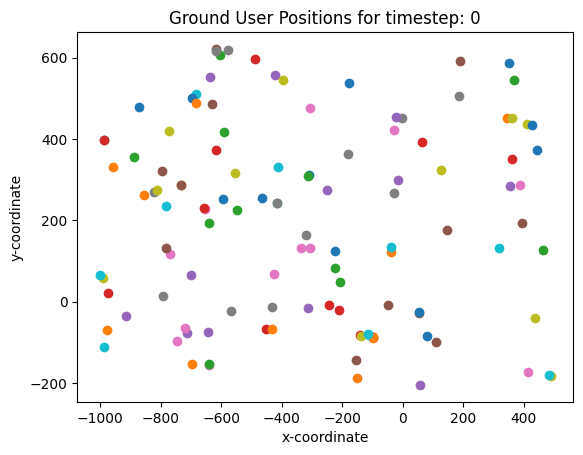

In [4]:
env.plotGUs()

In [5]:
# Using the default isotropic antenna configuration
env.setTransmitterArray()  # For the UAVs
env.setReceiverArray()  # For the Ground Users

In [6]:
# Making each of the UAV's antennas point at the ground
for i in ids:
    env.uavs[i].lookAt()

# We generate the radio map using env.computeRadioMap, then use the visualize method to look at it
radio_map = env.computeRadioMap(max_depth=2, num_samples=10000000, cell_size=(1,1))
    
env.visualize(radio_map=radio_map)

In [17]:
import json
from pathlib import Path

# 1) 改成你的 json 路径（cfg / scene json）
SCENE_JSON = Path("/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json")  # TODO: 替换

# 2) 读取
with open(SCENE_JSON, "r") as f:
    cfg = json.load(f)

# 3) 基本检查
print("Top-level keys:", list(cfg.keys()))
assert "buildings" in cfg and isinstance(cfg["buildings"], list) and len(cfg["buildings"]) > 0, "JSON 里没有 buildings 或为空"

b0 = cfg["buildings"][0]

print("\n=== buildings[0] keys ===")
print(list(b0.keys()))

# 4) 打印你关心的核心字段（用于后面生成 ply/xml）
print("\n=== Core fields (building[0]) ===")
print("building_id:", b0.get("building_id"))
print("zmin/zmax:", b0.get("zmin"), b0.get("zmax"))
print("roof_zmax:", b0.get("roof_zmax"))
print("source_ply:", b0.get("source_ply"))

fp = b0.get("footprint")
assert fp is not None and len(fp) >= 3, "building[0] footprint 缺失或点数不足"
print("footprint n_pts:", len(fp))
print("footprint first 3 pts:", fp[:3])

# 5) 可选：检查 footprint 是否闭合（你的示例是不闭合的，这是正常的）
is_closed = (fp[0] == fp[-1])
print("footprint closed?:", is_closed)


Top-level keys: ['meta', 'buildings']

=== buildings[0] keys ===
['xmin', 'xmax', 'ymin', 'ymax', 'zmin', 'zmax', 'center', 'size', 'building_id', 'num_parts', 'footprint', 'roof_zmax', 'source_ply']

=== Core fields (building[0]) ===
building_id: 213_North_Bloodworth_Apartments-roof__element_00000
zmin/zmax: 0.0 4.650027751922607
roof_zmax: 4.650027751922607
source_ply: /home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_scene/meshes/213_North_Bloodworth_Apartments-roof.ply
footprint n_pts: 7
footprint first 3 pts: [[253.8597869873047, 487.14306640625], [260.9128112792969, 485.1617736816406], [271.99346923828125, 484.471923828125]]
footprint closed?: False
